## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [10]:
categorical = [col for col in df.columns if df[col].dtype=='object']
numerical = [col for col in df.columns if df[col].dtype !='object']
print(numerical,categorical)

['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'] ['home', 'marital', 'records', 'job']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)

df_train, df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [83]:
y_train = df_train.default
y_val = df_val.default
y_test = df_test.default

In [84]:
del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
from sklearn.metrics import auc, roc_auc_score

In [26]:
df_train.sort_values(['seniority'],ascending=True)

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
884,0,owner,60,29,married,no,fixed,60,100,5000,0,800,960,0
1027,0,owner,60,31,married,yes,fixed,45,184,3500,0,1550,1679,1
2466,0,other,60,23,single,no,fixed,35,0,0,0,700,969,1
1994,0,other,36,37,married,no,others,75,75,0,0,500,800,1
1623,0,parents,36,26,single,no,partime,35,70,3500,350,375,500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,45,owner,12,60,married,no,freelance,35,52,19000,0,550,1240,0
4153,45,owner,30,64,married,no,freelance,45,157,20000,0,1000,1588,0
3459,45,other,48,62,married,no,fixed,45,100,0,0,450,935,0
3530,47,owner,48,61,married,no,fixed,35,110,5500,30,1200,1200,0


In [52]:
for v in numerical:
    df_in = df_train.copy()
    df_in = df_in.sort_values(v,ascending=True);
    print(v,auc(df_in[v],df_in.default))

seniority 5.5
time 15.0
age 13.0
expenses 66.5
income 158.0
assets 23551.0
debt 9721.0
amount 1663.5
price 3113.5
default 0.5


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [31]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [85]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
val_dict = df_val[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [32]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [86]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [87]:
y_pred =lr.predict_proba(X_val)[:,1] >= 0.5

In [88]:
roc_auc_score(y_pred,y_val)

0.727658099185275

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [56]:
from sklearn.metrics import precision_score, recall_score

In [61]:
thresholds = np.linspace(0,1,101)

D:\APPLICATIONS\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\APPLICATIONS\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\APPLICATIONS\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\APPLICATIONS\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

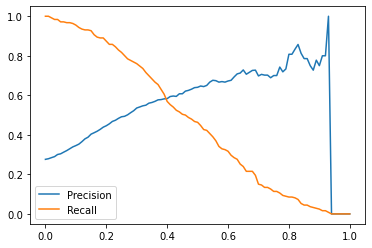

In [92]:
p = []
r = []
for t in thresholds:
    p.append(precision_score(y_val,lr.predict_proba(X_val)[:,1]>=t))
    r.append(recall_score(y_val,lr.predict_proba(X_val)[:,1]>=t))
plt.plot(thresholds,p,label ='Precision')
plt.plot(thresholds,r,label='Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [93]:
from sklearn.metrics import f1_score

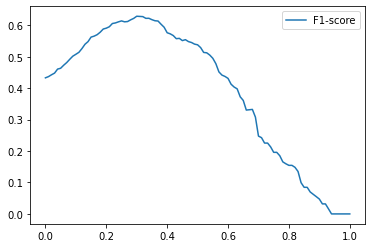

In [94]:
f = []
for t in thresholds:
    f.append(f1_score(y_val,lr.predict_proba(X_val)[:,1]>=t))
plt.plot(thresholds,f,label ='F1-score')
plt.legend()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [95]:
from sklearn.model_selection import KFold

In [97]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [99]:
a = []

for t,v in kfold.split(df_full_train):
    d_train = df_full_train.iloc[t]
    y2_train = d_train.default.values
    
    d_val = df_full_train.iloc[v]
    y2_val = d_val.default.values
    
    dvec = DictVectorizer(sparse=False)
    train2_dict = d_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
    val2_dict = d_val[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
    X2_train = dvec.fit_transform(train2_dict)
    X2_val = dvec.transform(val2_dict)
    
    mod = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    mod.fit(X2_train, y2_train)
    
    y2pred = mod.predict(X2_val)
    
    auc = roc_auc_score(y2_val,y2pred)
    a.append(auc)
    
np.mean(a), np.std(a)

(0.6688356766547482, 0.014061208371452744)

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [100]:
for  C in [0.01,0.1,1,10]:
    a = []

    for t,v in kfold.split(df_full_train):
        d_train = df_full_train.iloc[t]
        y2_train = d_train.default.values

        d_val = df_full_train.iloc[v]
        y2_val = d_val.default.values

        dvec = DictVectorizer(sparse=False)
        train2_dict = d_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
        val2_dict = d_val[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
        X2_train = dvec.fit_transform(train2_dict)
        X2_val = dvec.transform(val2_dict)

        mod = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        mod.fit(X2_train, y2_train)

        y2pred = mod.predict(X2_val)

        auc = roc_auc_score(y2_val,y2pred)
        a.append(auc)
    print('C: %s, auc: %0.3f,  std: %0.3f'%(C,np.mean(a),np.std(a)))


C: 0.01, auc: 0.611,  std: 0.013
C: 0.1, auc: 0.663,  std: 0.014
C: 1, auc: 0.669,  std: 0.014
C: 10, auc: 0.659,  std: 0.020


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.